In [1]:
import numpy as np
from sklearn_ensemble_cv import Ensemble, comp_empirical_ecv, cross_validation_ecv, make_grid

We make up some fake data for illustration.

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=300, n_features=100,
                       n_informative=10, n_targets=1,
                       random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# The Ensemble class

For users who want to have more control of the ensemble predictor, this section introduces lower-level class and object that we use to implement the cross-validation methods.
For users who just want to use easy interface functions, you can safely skip this section.

We provide `Ensemble` a class for ensemble predictor, whose base class is `sklearn.ensemble.BaggingRegressor`.
This means that the usage of `Ensemble` is basically the same as the latter, except the new class includes several new member functions that we will illustrate below.



## Initialize an object

The initialization of `Ensemble` class is the same as `sklearn.ensemble.BaggingRegressor`, where 

1. The base estimator object, whose hyperparameter `kwargs_regr` is specified when it is initialized. In the following example, we use decision tree as the base estimator. 
2. The hyperparameters for building an ensemble, such as `n_estimators`, `max_samples`, `max_features`, and etc.

In [3]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr = Ensemble(estimator=DecisionTreeRegressor(**kwargs_regr), n_estimators=100, **kwargs_ensemble)

After the ensemble object `regr` is initialized, we can fit the data and get the prediction:

In [4]:
regr.fit(X_train, y_train)
regr.predict(X_test)

array([  70.23396371, -182.58138254, -101.18383671,  -56.21812489,
        -24.1509203 ,  -80.55427682,  -26.05180353,  -29.27014189,
        -13.13677842,   39.3139393 ,   35.62489681, -137.78556102,
        225.63794764,   78.18069272,  125.18230402,   57.8630433 ,
        -82.00688554, -104.13571476,  -32.47847558,   16.05660559,
         -7.99815216, -100.9500727 ,   49.26143715,   93.78488146,
         31.51940601,  -41.87014185,  138.63315023,  -46.69257716,
         59.64942528,  -18.00586823, -113.2085673 ,   74.66305842,
       -132.15682473,   38.27447023,  -74.97420797,   98.25988659,
        -44.57687795,   57.70456432,  141.42654703,   56.16192447,
        115.99054251,  170.12096277,  -19.9368687 ,   77.27520233,
         46.96778833,  -56.60430355,  152.59543006,   70.32912719,
       -156.148454  ,   -7.19352637,   64.79158232, -180.54656167,
         53.45175638,   46.08532312,  158.77208672, -139.98518844,
         65.99980672,   97.54784702,  -74.99989171,  -19.74156

## Prediction of individual estimators

We provide a new function `predict_individual` to obtain prediction values from all estimators in the ensemble.
Since we have $n=33$ observations and $M=10$ estimators, the resulting prediction would be of shape $(n,M)=(33,10)$.

In [5]:
Y_train_hat = regr.predict_individual(X_train)
Y_train_hat.shape

(201, 100)

## Compute ECV estimate of the prediction risk

In [6]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M0=20, return_df=True)
df_est

,M,estimate
0,1,53096.499188
1,2,34601.479982
2,3,28436.473580
3,4,25353.970379
4,5,23504.468459
...,...,...
95,96,16491.773677
96,97,16487.801379
97,98,16483.910148
98,99,16480.097528


We can also compute the test error on the test set:

In [7]:
df_risk = regr.compute_risk(X_test, y_test, return_df=True)
df_risk

,M,risk
0,1,51431.668388
1,2,39123.869850
2,3,32440.606480
3,4,29950.753833
4,5,25533.965993
...,...,...
95,96,21063.038771
96,97,21090.903436
97,98,21161.999616
98,99,21101.676215


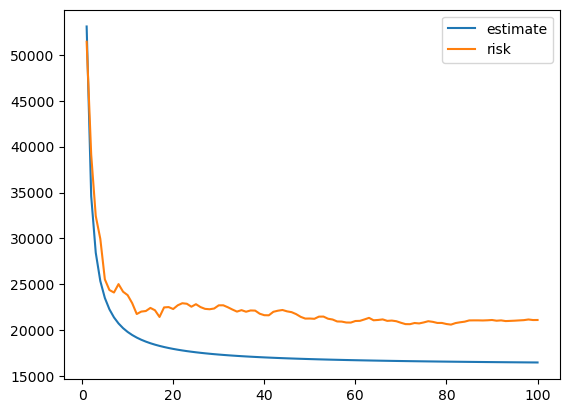

In [8]:
import matplotlib.pyplot as plt
plt.plot(df_est['M'], df_est['estimate'], label='estimate')
plt.plot(df_risk['M'], df_risk['risk'], label='risk')
plt.legend()
plt.show()

We can also get a risk estimate beyond $M=100$, which gives us a sense how much improvement one can get if we further increase the ensemble size.

In [9]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M_test=1000, M0=20, return_df=True)
df_est

,M,estimate
0,1,53096.499188
1,2,34601.479982
2,3,28436.473580
3,4,25353.970379
4,5,23504.468459
...,...,...
995,996,16143.599369
996,997,16143.562119
997,998,16143.524943
998,999,16143.487842


# ECV estimate for one configuration of ensemble predictors


The function `comp_empirical_ecv` provides an easy way to fit and get risk estimate from ECV.
Similar to the previous section, one need to provide
1. Data: `X_train, y_train`.
2. A regressor class and the parameters to initialize it: `DecisionTreeRegressor, kwargs_regr=kwargs_regr`.
3. The parameters for building the ensemble (with `M` denoting `n_estimators`): `kwargs_ensemble=kwargs_ensemble, M=100`.
4. Extra optional parameters for ECV.

The function returns two objects:
1. An ensemble predictor (an object of `Ensemble`)
2. A np.array or pd.DataFrame object, containing the risk estimates given by ECV.

In [10]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr, risk_ecv = comp_empirical_ecv(X_train, y_train, DecisionTreeRegressor, kwargs_regr=kwargs_regr,
                   kwargs_ensemble=kwargs_ensemble, M=100)

One can also pass kwargs `X_val=X_test, Y_val=y_test` to get the actual test errors.

# ECV for tuning hyperparameters

For tuning hyperparameters, such as `max_samples` and `max_features` for the ensemble predictors, and `max_depth` and `min_samples_leaf` for all base predictors, we can make a grid of tuning hyperparameters as follows:

In [11]:
from sklearn_ensemble_cv.utils import make_grid
grid = make_grid({
    'max_samples':[0.6,0.7],
    'max_depth':np.array([6,7], dtype=int),
    })

In [12]:

res_ecv, info_ecv = cross_validation_ecv(X_train, y_train, grid, 
                     DecisionTreeRegressor, kwargs_regr={},
                     M=100, kwargs_ensemble={}, return_df=True
                     )

In [13]:
res_ecv

,max_samples,max_depth,risk_ecv1,risk_ecv2,risk_ecv3,risk_ecv4,risk_ecv5,risk_ecv6,risk_ecv7,risk_ecv8,...,risk_ecv91,risk_ecv92,risk_ecv93,risk_ecv94,risk_ecv95,risk_ecv96,risk_ecv97,risk_ecv98,risk_ecv99,risk_ecv100
0,0.6,6,52507.916966,35931.238209,30405.678623,27642.898830,25985.230954,24880.119037,24090.753382,23498.729140,...,19718.882061,19714.922032,19711.047166,19707.254743,19703.542161,19699.906925,19696.346642,19692.859017,19689.441850,19686.093026
1,0.6,7,53476.652171,36363.174209,30658.681555,27806.435228,26095.087431,24954.188900,24139.261378,23528.065737,...,19625.816641,19621.728376,19617.728030,19613.812799,19609.979993,19606.227037,19602.551462,19598.950899,19595.423074,19591.965806
2,0.7,6,50480.383672,34607.104402,29316.011312,26670.464767,25083.136840,24024.918222,23269.047781,22702.144950,...,19082.688413,19078.896421,19075.185977,19071.554478,19067.999433,19064.518450,19061.109241,19057.769607,19054.497441,19051.290718
3,0.7,7,51692.828705,35132.686526,29612.639133,26852.615436,25196.601218,24092.591739,23304.013540,22712.579891,...,18936.503515,18932.547437,18928.676436,18924.887797,18921.178919,18917.547308,18913.990577,18910.506432,18907.092673,18903.747190


In [14]:
info_ecv

{'delta': 0.0,
 'best_params': {'max_samples': 0.7, 'max_depth': 7.0},
 'best_n_estimators': inf,
 'M_max': inf}